# U-Net Template
Supplementary Materials, *Junha Park* <br/>
[Reference](https://www.kaggle.com/c/data-science-bowl-2018/data) : Kaggle data science bowl 2018 Round 1 <br/>

In [1]:
import os
import time
import copy
import torch
import shutil
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform
import cv2

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import nn
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

/home/hahajjjun/anaconda3/envs/molly/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
import sys
sys.executable

'/home/hahajjjun/anaconda3/envs/molly/bin/python'

### Load Data with Dataset

In [2]:
def get_transforms(mean, std):
    list_transforms = []
    list_transforms.extend(
        [
            HorizontalFlip(p=0.5)
        ]
    )
    list_transforms.extend(
        [
            Normalize(mean = mean, std = std, p=1),
            ToTensorV2(),
        ]
    )
    return Compose(list_transforms)

In [3]:
class Nuclei_dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.folders = os.listdir(path)
        self.transforms = get_transforms(0.5, 0.5)
    
    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        image_folder = os.path.join(self.path, self.folders[idx], 'images/')
        mask_folder = os.path.join(self.path, self.folders[idx], 'masks/')
        image_path = os.path.join(image_folder, os.listdir(image_folder)[0])
        img = io.imread(image_path)[:,:,:3].astype('float32')
        img = transform.resize(img, (128,128))
        mask = self.get_mask(mask_folder, 128, 128).astype('float32')
        augmented = self.transforms(image = img, mask = mask)
        img = augmented['image']
        mask = augmented['mask']
        #print(mask.shape)
        mask = mask.permute(2,0,1)
        
        return (img, mask)
    
    def get_mask(self, mask_folder, IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder, mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask, mask_)
        return mask

In [4]:
base_dir = '/home/hahajjjun/Junha Park/train'
data = Nuclei_dataset(base_dir)


In [5]:
print(data.__len__())
data.__getitem__(0)

670


/tmp/ipykernel_30088/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


(tensor([[[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602, -0.9623,  ..., -0.9449, -0.9625, -0.9719],
          [-0.9351, -0.9517, -0.9566,  ..., -0.9445, -0.9629, -0.9737],
          ...,
          [-0.9767, -0.9782, -0.9817,  ..., -0.9828, -0.9843, -0.9843],
          [-0.9780, -0.9767, -0.9767,  ..., -0.9843, -0.9843, -0.9828],
          [-0.9782, -0.9784, -0.9767,  ..., -0.9843, -0.9843, -0.9841]],
 
         [[-0.9588, -0.9608, -0.9612,  ..., -0.9472, -0.9658, -0.9739],
          [-0.9514, -0.9602,

In [6]:
for img, msk in data:
    print(img.shape)
    print(msk.shape)
    break

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


/tmp/ipykernel_30088/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


In [7]:
def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image = std*image + mean
    image = image.clip(0,1)
    image = (image*255).astype(np.uint8)
    return image

In [8]:
trainset, valset = random_split(data, [580, 90])
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=10)

/tmp/ipykernel_30088/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


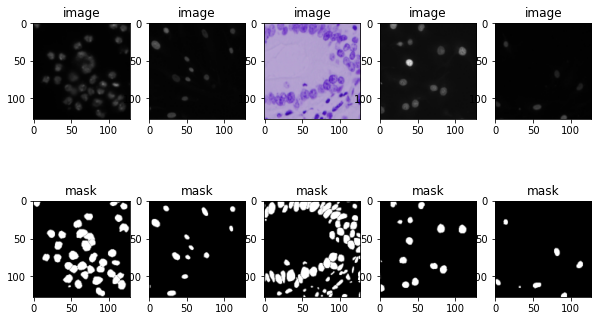

In [9]:
def plot_img(dataloader, no_):
    iter_ = iter(dataloader)
    images, masks = next(iter_)
    images = images.to(device)
    masks = masks.to(device)
    plt.figure(figsize=(10,6))
    for idx in range(no_):
        image = image_convert(images[idx])
        plt.subplot(2, no_, idx+1)
        plt.title('image')
        plt.imshow(image)
    for idx in range(no_):
        mask = mask_convert(masks[idx])
        plt.subplot(2, no_, idx+no_+1)
        plt.title('mask')
        plt.imshow(mask, cmap='gray')
    plt.show()
    
plot_img(train_loader, 5)

In [16]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        # Contraction
        self.dblock1 = self.double_conv(3, 64)
        self.dblock2 = self.double_conv(64, 128)
        self.dblock3 = self.double_conv(128,256)
        self.dblock4 = self.double_conv(256,512)
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) 
        
        # Inflation
        self.dblock5 = self.double_conv(256 + 512, 256)
        self.dblock6 = self.double_conv(128 + 256, 128)
        self.dblock7 = self.double_conv(128 + 64, 64)

        self.last_layer = nn.Conv2d(64,1,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        conv1 = self.dblock1(x)
        x = self.pool(conv1)

        conv2 = self.dblock2(x)
        x = self.pool(conv2)

        conv3 = self.dblock3(x)
        x = self.pool(conv3)

        conv4 = self.dblock4(x)
        
        x = self.upsample(conv4)

        x = torch.cat([x, conv3], dim=1)

        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        
        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        
        x = self.dblock7(x)

        out = self.last_layer(x)
        out = self.sigmoid(out)
        return out
    
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels, 0.01),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels, 0.01)
        )

### BiO-Net : [Reference](https://github.com/tiangexiang/BiO-Net/blob/master/pytorch_version/model.py)

In [12]:
class BiONet(nn.Module):
    def __init__(self, iterations = 2, num_layers = 3):
        super().__init__()
        self.iterations = iterations
        self.num_layers = num_layers
        self.filter_list = [int(64 * (2**i)) for i in range(self.num_layers+1)]
        
        self.reuse_convs = []
        self.encoders = []
        self.reuse_deconvs = []
        self.decoders = []
        
        # Pre-transform block
        in_channel = 3
        out_channel = self.filter_list[0]
        self.pre_transform_conv_block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel, momentum = 0.01),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel, momentum = 0.01),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel, momentum = 0.01),
            nn.MaxPool2d(2)            
        )
        
        # Reusing block
        for iteration in range(self.iterations):
            for layer in range(self.num_layers):
                in_channel = self.filter_list[layer]*2
                mid_channel = self.filter_list[layer]
                out_channel = self.filter_list[layer+1]
                
                if iteration == 0: # No items to reuse at first iter.
                    conv1 = nn.Conv2d(in_channel, mid_channel, kernel_size = 3, padding = 1)
                    conv2 = nn.Conv2d(mid_channel, mid_channel, kernel_size = 3, padding = 1)
                    conv3 = nn.Conv2d(mid_channel, out_channel, kernel_size = 3, padding = 1)
                    self.reuse_convs.append((conv1, conv2, conv3))
                
                convs = nn.Sequential(
                    self.reuse_convs[layer][0],
                    nn.ReLU(),
                    nn.BatchNorm2d(mid_channel, momentum = 0.01),
                    self.reuse_convs[layer][1],
                    nn.ReLU(),
                    nn.BatchNorm2d(mid_channel, momentum = 0.01)
                )
                
                down = nn.Sequential(
                    self.reuse_convs[layer][2],
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channel, momentum = 0.01),
                    nn.MaxPool2d(2)
                )
                self.add_module("iteration{0}_layer{1}_encoder_convs".format(iteration, layer), convs)
                self.add_module("iteration{0}_layer{1}_encoder_down".format(iteration, layer), down)
                self.encoders.append((convs, down))
                
                in_channel = self.filter_list[self.num_layers-layer]+self.filter_list[self.num_layers-1-layer]
                out_channel = self.filter_list[self.num_layers-1-layer]
                
                if iteration == 0:
                    conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1)
                    conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1)
                    conv3 = nn.ConvTranspose2d(out_channel, out_channel, kernel_size = 3, padding = 1, stride = 2, output_padding = 1)
                    self.reuse_deconvs.append((conv1, conv2, conv3))
                
                convs = nn.Sequential(
                    self.reuse_deconvs[layer][0],
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channel, momentum = 0.01),
                    self.reuse_deconvs[layer][1],
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channel, momentum = 0.01)
                )
                
                up = nn.Sequential(
                    self.reuse_deconvs[layer][2],
                    nn.ReLU(),
                    nn.BatchNorm2d(out_channel, momentum = 0.01)
                )
                
                self.add_module("iteration{0}_layer{1}_decoder_convs".format(iteration, layer), convs)
                self.add_module("iteration{0}_layer{1}_decoder_up".format(iteration, layer), up)
                self.decoders.append((convs, up))
                    
        # Bridging Block at U-Net
        in_channel = self.filter_list[-1]
        out_channel = self.filter_list[-1]
        self.middles = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel, momentum = 0.01),
            nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel, momentum = 0.01),
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size = 3, padding = 1, stride = 2, output_padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel, momentum = 0.01)
        )
        
        # Post-Transform conv block : concatenate outputs from each iters as inputs
        out_channel = self.filter_list[0]
        in_channel = out_channel * self.iterations
        self.post_transform_conv_block = nn.Sequential(
            #nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1),
            nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel, momentum=0.01),
            nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel, momentum=0.01),
            nn.Conv2d(out_channel, 1, 1),
            nn.Sigmoid(),
        )
        
    def forward(self,x):
        enc = [None for i in range(self.num_layers)]
        dec = [None for i in range(self.num_layers)]
        all_output = [None for i in range(self.iterations)]
        x = self.pre_transform_conv_block(x)
        e_i = 0
        d_i = 0
        for iteration in range(self.iterations):
            # Encoding Step
            for layer in range(self.num_layers):
                if layer == 0:
                    x_in = x
                x_in = self.encoders[e_i][0](torch.cat([x_in, x_in if dec[-1 - layer] is None else dec[-1 - layer]], dim=1))
                enc[layer] = x_in
                x_in = self.encoders[e_i][1](x_in)
                e_i = e_i + 1
            x_in = self.middles(x_in)
            # Decoding Step
            for layer in range(self.num_layers):
                x_in = self.decoders[d_i][0](torch.cat([x_in, enc[-1 - layer]], dim=1))
                dec[layer] = x_in
                x_in = self.decoders[d_i][1](x_in)
                d_i = d_i + 1
            all_output[iteration] = x_in
        #x_in = torch.cat(all_output, dim=1)
        out = self.post_transform_conv_block(x_in)
        return out

In [17]:
model = Unet().to(device)
#model = BiONet().to(device)
model

Unet(
  (dblock1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=0.01, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=0.01, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dblock2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=0.01, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(128, eps=0.01, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=0.01, mo

In [18]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final
    
## IOU computation
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou

def iou_batch(y_pred,y):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    y_pred = F.sigmoid(y_pred)
    y_pred = y_pred.clone().cpu().detach().numpy()
    y = y.clone().cpu().detach().numpy() 
    
    for pred, label in zip(y_pred, y):
        ious.append(iou_(pred, label))
    iou = np.nanmean(ious)
    return iou    

In [19]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [21]:
checkpoint_path = '/home/hahajjjun/Junha Park/model'
best_model_path = '/home/hahajjjun/Junha Park/bestmodel/bestmodel.pt'
epochs = 20
criterion = DiceBCELoss()
learning_rate = 1e-2 #1e-3 for unet
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
valid_loss_min = 3.95275

train_loss,val_loss = [],[]
train_iou,val_iou = [],[]

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    start_time = time.time()
     

    
    running_train_loss = []
    running_train_score = []
    for image,mask in train_loader: 
            image = image.to(device,dtype=torch.float)
            mask = mask.to(device,dtype=torch.float)
            pred_mask = model.forward(image) # forward propogation
            #print(pred_mask.shape, mask.shape)
            loss = criterion(pred_mask,mask)
            score = iou_batch(pred_mask,mask)
            optimizer.zero_grad() # setting gradient to zero
            loss.backward()
            optimizer.step()
            running_train_loss.append(loss.item())
            running_train_score.append(score)
                              

    else:           
        running_val_loss = []
        running_val_score = []
        with torch.no_grad():
            for image,mask in val_loader:
                    image = image.to(device,dtype=torch.float)
                    mask = mask.to(device,dtype=torch.float)                            
                    pred_mask = model.forward(image)
                    loss = criterion(pred_mask,mask)
                    score = iou_batch(pred_mask,mask)
                    running_val_loss.append(loss.item())
                    running_val_score.append(score)

                                    
    
    epoch_train_loss,epoch_train_score = np.mean(running_train_loss) ,np.mean(running_train_score)
    print('Train loss : {} iou : {}'.format(epoch_train_loss,epoch_train_score))                       
    train_loss.append(epoch_train_loss)
    train_iou.append(epoch_train_score)
    
    epoch_val_loss,epoch_val_score = np.mean(running_val_loss),np.mean(running_val_score)
    print('Validation loss : {} iou : {}'.format(epoch_val_loss,epoch_val_score))                                
    val_loss.append(epoch_val_loss)
    val_iou.append(epoch_val_score)
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_val_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_val_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch 1/20


/tmp/ipykernel_30088/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


Train loss : 0.7112686716277024 iou : 0.1510480325554242
Validation loss : 0.7100696365038554 iou : 0.14379334372894062
Validation loss decreased (3.952750 --> 0.710070).  Saving model ...
4m 50s
Epoch 2/20
Train loss : 0.6940610542379576 iou : 0.15550698093978682
Validation loss : 0.7044840719964769 iou : 0.1459108703102032
Validation loss decreased (0.710070 --> 0.704484).  Saving model ...
4m 51s
Epoch 3/20
Train loss : 0.6929717403033684 iou : 0.15531233828344046
Validation loss : 0.7033584581481086 iou : 0.1459005866313137
Validation loss decreased (0.704484 --> 0.703358).  Saving model ...
4m 55s
Epoch 4/20
Train loss : 0.6908212252731981 iou : 0.15681330873265598
Validation loss : 0.6997494300206503 iou : 0.14743788537178665
Validation loss decreased (0.703358 --> 0.699749).  Saving model ...
4m 53s
Epoch 5/20
Train loss : 0.689718072784358 iou : 0.1569632159953901
Validation loss : 0.7029852668444315 iou : 0.14697267759630184
4m 50s
Epoch 6/20
Train loss : 0.6906753459881092 io

In [1]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.title('Loss Plot')
plt.subplot(1,2,2)
plt.plot(train_iou,label='train_iou')
plt.plot(val_iou,label='val_iou')
plt.legend()
plt.title('IOU Plot')
plt.show()

NameError: name 'plt' is not defined

In [17]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

/tmp/ipykernel_17053/2539660355.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)


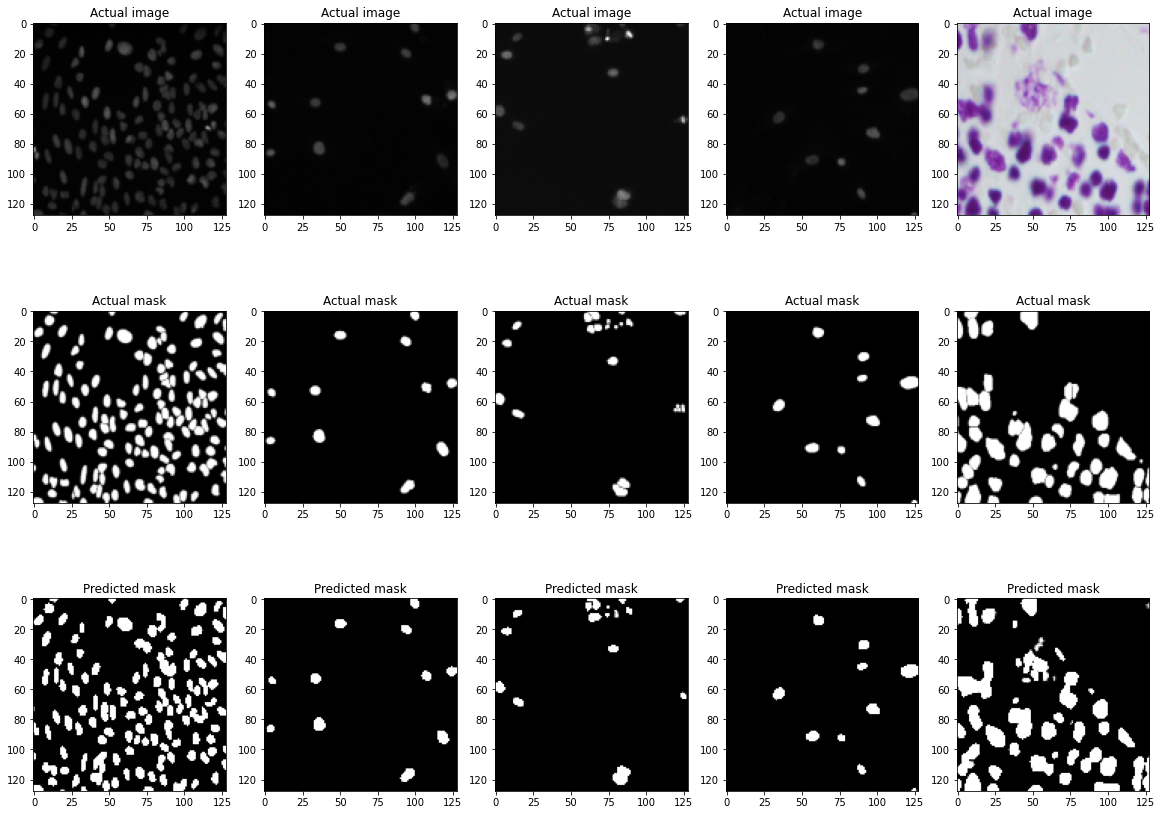

tensor(0.7731, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8305, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6984, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8496, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7530, device='cuda:0', grad_fn=<DivBackward0>)


In [22]:
iter_ = iter(val_loader)
image,mask = next(iter_)
image = image.to(device,dtype=torch.float)
mask = mask.to(device,dtype=torch.float)
y_pred = model.forward(image)


plt.figure(figsize=(20,15))
for i in range(0,5):
    plt.subplot(3,5,i+1)
    plt.title('Actual image')
    plt.imshow(image_convert(image[i]))
for i in range(0,5):
    plt.subplot(3,5,i+5+1)
    plt.title('Actual mask')
    plt.imshow(mask_convert(mask[i]),cmap='gray')
for i in range(0,5):
    plt.subplot(3,5,i+10+1)
    plt.title('Predicted mask')
    plt.imshow(mask_convert(y_pred[i]),cmap='gray')
plt.show()

for i in range(0,5):
    print(iou_(y_pred[i], mask[i]))